In [1]:
from utilities import *
from model import *
from metrics import Metrics
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim
from tqdm import tqdm
import time
import multiprocessing
from sklearn import svm
from gensim.test.utils import get_tmpfile
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import csr_matrix as sparse
from os import listdir
from os.path import isfile, join
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [2]:
file_dir_our      = "/Users/igoradamski/Documents/cambridge/MLMI/nlp/coursework/nlp/data"
our_data      = DataHandler(file_dir_our)
our_data.readOurData()

train, test   = our_data.blind_test()

cv_train      = DataHandler()
cv_train(train.x_train, train.y_train)

blind_test = DataHandler()
blind_test(test.x_train, test.y_train)

100%|██████████| 2000/2000 [00:00<00:00, 2009.48it/s]


In [3]:
all_data_ordered = DataHandler()
all_data_ordered(cv_train.x_data + blind_test.x_data,cv_train.y_data + blind_test.y_data)

# create vector data from doc2vec


In [228]:
model_path = '/Users/igoradamski/Documents/cambridge/MLMI/nlp/coursework/nlp/doc2vec_models/'
model_name = 'model_dm=0,hs=1,min_count=10,vector_size=50,window=5.bin'

doc2vec_model = MyDoc2Vec()
doc2vec_model.load(model_path+model_name)

vector_data = DataHandler()
vector_data(DataHandler.applyDoc2Vec(all_data_ordered.x_data, doc2vec_model.model), all_data_ordered.y_data)

# create vector data from bow

In [4]:
bow2vec_model = BoW2Vec([4,4], ['uni', 'bi'])
bow2vec_model.getFullVocab(all_data_ordered)

vector_data = DataHandler()
vector_data(bow2vec_model.text2vec(all_data_ordered), all_data_ordered.y_data)
#vector_data.x_data = sparse(vector_data.x_data)

100%|██████████| 2000/2000 [00:05<00:00, 382.04it/s]


# create vectors from representative words

In [5]:
def text2vec(model, train_data):

        idx_vocab = {word:idx for idx, word in enumerate(model.vocabulary)}

        documents = []
        for document in tqdm(train_data):

            doc_vocab = Vocabulary.getVocabularyByDocument(document, model.grams)
            occurrences = np.zeros(len(idx_vocab.keys()))

            for feature in doc_vocab.keys():

                try:
                    occurrences[idx_vocab[feature]] += doc_vocab[feature]
                except:
                    continue

            documents.append(occurrences)

        return documents

In [6]:
# Get all positive words
positive_words = []
with open('positive-words.txt', 'r') as f:
    positive_words = f.read()
positive_words = positive_words.split('\n')

In [7]:
# Get all negative words
negative_words = []
with open('negative-words.txt', 'r') as f:
    negative_words = f.read()
negative_words = negative_words.split('\n')

In [131]:
np.array(positive_words)[np.random.choice(10, 10, replace = False)]

array(['abundance', 'abounds', 'accessible', 'abound', 'acclaim',
       'acclamation', 'accessable', 'acclaimed', 'abundant', 'accolade'],
      dtype='<U20')

In [8]:
whole_vocab = [word for word in bow2vec_model.vocabulary]

In [14]:
10*np.random.choice(2,64567, p = [0.9, 0.1])

array([0, 0, 0, ..., 0, 0, 0])

In [73]:
# uniforms
np.random.seed(1023123)
random_1000_vec = text2vec(bow2vec_model, \
                           [[whole_vocab[idx] for idx in np.random.choice(len(whole_vocab), 1000)]])
#uniform_10_vec = [np.ones(64567)]
uniform_10_vec = text2vec(bow2vec_model, \
                           [[whole_vocab[idx] for idx in np.random.choice(len(whole_vocab), 1000)]])
# positive
random_1000_positive_1 = [10*np.random.choice(2,64567, p = [0.999, 0.001])+text2vec(bow2vec_model, \
                            [[positive_words[idx] for idx in np.random.choice(len(positive_words), 1000)]])[0]]
random_1000_positive_2 = [10*np.random.choice(2,64567, p = [0.999, 0.001])+text2vec(bow2vec_model, \
                            [[positive_words[idx] for idx in np.random.choice(len(positive_words), 1000)]])[0]]

#random_1000_positive_1 = text2vec(bow2vec_model, \
                            #[[positive_words[idx] for idx in np.random.choice(len(positive_words), 2000)]])



# negative
random_1000_negative_1 = [10*np.random.choice(2,64567, p = [0.999, 0.001])+text2vec(bow2vec_model, \
                            [[negative_words[idx] for idx in np.random.choice(len(negative_words), 8500)]])[0]]
random_1000_negative_2 = [10*np.random.choice(2,64567, p = [0.999, 0.001])+text2vec(bow2vec_model, \
                            [[negative_words[idx] for idx in np.random.choice(len(negative_words), 8500)]])[0]]



100%|██████████| 1/1 [00:00<00:00, 47.56it/s]


In [56]:
random_1000_positive_1[0].sum()
#vector_data.x_data[0].sum()
#text2vec(bow2vec_model, [[positive_words[idx] for idx in np.random.choice(len(positive_words), 200)]])[0].sum()

5580.0

In [221]:
len(random_1000_negative_1[0])

64567

In [74]:
rich_data = sparse(vector_data.x_data + random_1000_vec + uniform_10_vec + \
            random_1000_positive_1 + random_1000_positive_2 + random_1000_negative_1 + random_1000_negative_2)

### d2v

In [11]:
# positive
incredible_vec = DataHandler.applyDoc2Vec([['what', 'amazing', 'movie', 'had', 'so', 'much', 'fun',
                                           'I', 'want', 'to', 'watch', 'it', 'again', 'funny', 
                                           'witty', 'exciting']], doc2vec_model.model)
outstanding_vec = DataHandler.applyDoc2Vec([['outstanding']], doc2vec_model.model)
whole_good_review = DataHandler.applyDoc2Vec([['great','wow','amazing','the','best','seen','this','is', \
                                              'the','best', 'movie', 'ever', 'fantastic', 'acting',\
                                             'beautiful', 'lighting']], doc2vec_model.model)

# negative
very_bad_vec = DataHandler.applyDoc2Vec([['very', 'bad']], doc2vec_model.model)
awful_vec = DataHandler.applyDoc2Vec([['terribe']], doc2vec_model.model)
whole_bad_review = DataHandler.applyDoc2Vec([['absolutely','terrible', 'movie', 'I', 'hated', 'every',\
                                            'moment', 'of', 'it', 'stupid', 'and', 'dull', \
                                            'sucks', 'unfunny', 'boring', 'worst', 'i', \
                                            'barely', 'survived', 'never', 'watching', 'again',\
                                             'waste', 'of', 'time']], doc2vec_model.model)

NameError: name 'doc2vec_model' is not defined

In [182]:
rich_data = vector_data.x_data + incredible_vec + outstanding_vec + \
            whole_good_review + very_bad_vec + awful_vec + whole_bad_review

In [75]:
pca = TSNE(n_components=2, random_state = 12333213)
pca = pca.fit_transform(rich_data)

In [244]:
pca.explained_variance_ratio_

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_ratio_'

In [9]:
pca.shape

(2006, 2)

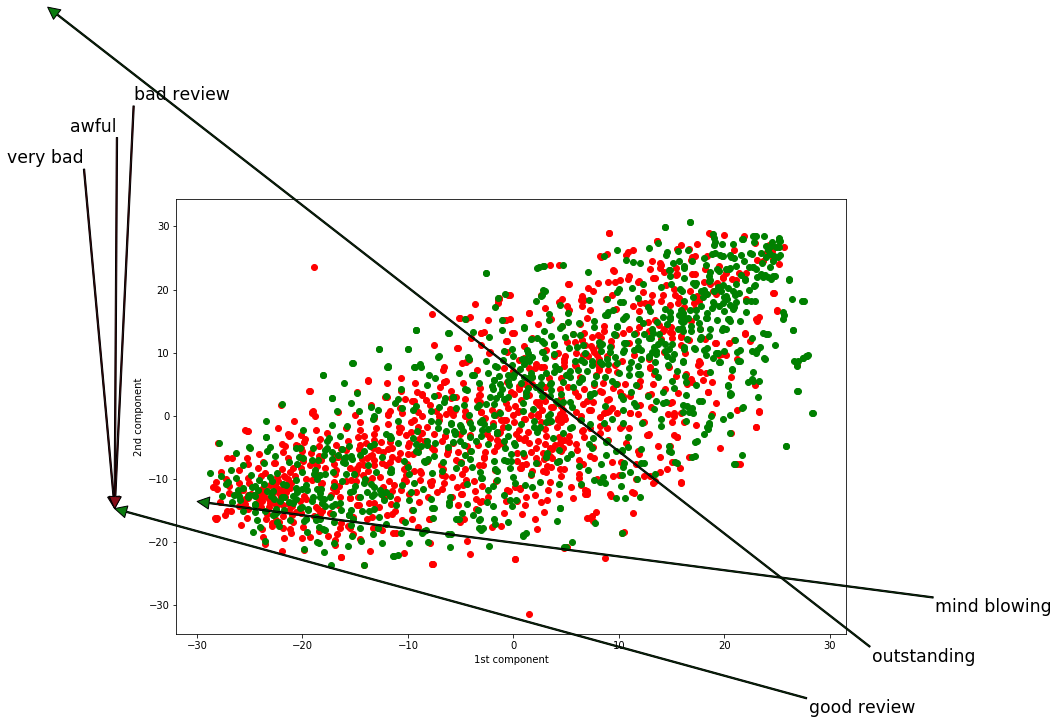

In [205]:
# PLOT FOR D2V
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)

# First plot everything
ax.scatter(pca[np.where(np.array(vector_data.y_data) == 0), 0], \
           pca[np.where(np.array(vector_data.y_data) == 0), 1], color = 'red')

ax.scatter(pca[np.where(np.array(vector_data.y_data) == 1), 0], \
           pca[np.where(np.array(vector_data.y_data) == 1), 1], color = 'green')

#ax.scatter(pca[2000:2003, 0], pca[2000:2003, 1], color = '#0A7A0E')
for i, txt in enumerate(['mind blowing','outstanding','good review']):
    ax.annotate(txt, (pca[2000+i, 0], pca[2000+i, 1]), xytext = (40-6*i, -31-8*i), \
                arrowprops=dict(facecolor='#0A7A0E', shrink = 0, width=1.3), fontsize = 'xx-large', annotation_clip=False)

#ax.scatter(pca[2003:2006, 0], pca[2003:2006, 1], color = '#860C17')
for i, txt in enumerate(['very bad','awful','bad review']):
    ax.annotate(txt, (pca[2003+i, 0], pca[2003+i, 1]), xytext = (-48+6*i, 40+5*i), \
                arrowprops=dict(facecolor='#860C17', shrink = 0, width=1.3), fontsize = 'xx-large', annotation_clip=False)

ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')

    
plt.show()

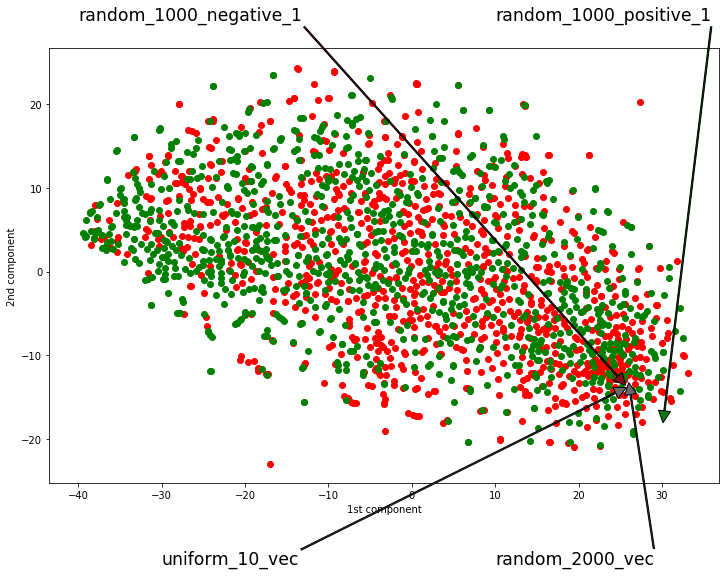

In [76]:
#PLOT FOR BOW
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)

# First plot everything
ax.scatter(pca[np.where(np.array(vector_data.y_data) == 0), 0], \
           pca[np.where(np.array(vector_data.y_data) == 0), 1], color = 'red')

ax.scatter(pca[np.where(np.array(vector_data.y_data) == 1), 0], \
           pca[np.where(np.array(vector_data.y_data) == 1), 1], color = 'green')

#ax.scatter(pca[2000:2003, 0], pca[2000:2003, 1], color = '#0A7A0E')
for i, txt in enumerate(['random_2000_vec','uniform_10_vec']):
    ax.annotate(txt, (pca[2000+i, 0], pca[2000+i, 1]), xytext = (10-i*40, -35), \
                arrowprops=dict(facecolor='dimgray', shrink = 0, width=1.3), fontsize = 'xx-large', annotation_clip=False)

for i, txt in enumerate(['random_1000_positive_1']):
    ax.annotate(txt, (pca[2002+i, 0], pca[2002+i, 1]), xytext = (10, 30), \
                arrowprops=dict(facecolor='#0A7A0E', shrink = 0, width=1.3), fontsize = 'xx-large', annotation_clip=False)


#ax.scatter(pca[2003:2006, 0], pca[2003:2006, 1], color = '#860C17')
for i, txt in enumerate(['random_1000_negative_1']):
    ax.annotate(txt, (pca[2004+i, 0], pca[2004+i, 1]), xytext = (-40, 30), \
                arrowprops=dict(facecolor='#860C17', shrink = 0, width=1.3), fontsize = 'xx-large', annotation_clip=False)

ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')

    
plt.show()

In [218]:
pca.shape

(2002, 2)

In [172]:
np.where(pca[:,1] < -30)

(array([467]),)

In [23]:
pca[2000:]

array([[ 31.132797, -12.003613],
       [ 31.630323, -12.421255],
       [ 31.89866 , -12.196027],
       [ 31.472782, -12.621447],
       [ 31.96135 , -12.489167],
       [ 31.58877 , -12.693163]], dtype=float32)